  # Projet Mushroom 

  ### 1️⃣ Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import recall_score, f1_score, make_scorer
import joblib



  ### 2️⃣ EDA

#### 2.1 Chargement des données

In [2]:
# Charger le dataset
df = pd.read_csv("../dataset/mushroom_classification.csv", sep=';')
df.describe()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,24487,21203,21221,21217,21187,21252,21201,21263,21185,21114,...,21246,21125,21257,21184,21198,21193,21210,21218,21198,21209
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,13525,7222,7157,4519,11610,6586,16783,15171,13200,3475,...,10001,8090,7901,21184,14862,14804,8057,4790,7940,6202


 #### 2.2 Afficher la répartition entre "Edible" et "Poisonous"

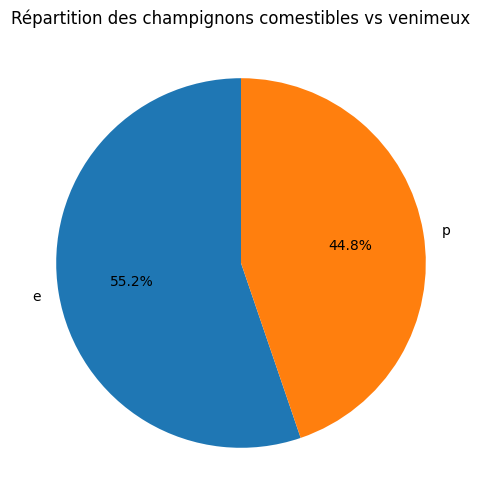

In [3]:
counts = df['class'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des champignons comestibles vs venimeux")
plt.show()


#### 2.3 Afficher le nombre de valeurs manquantes par categorie

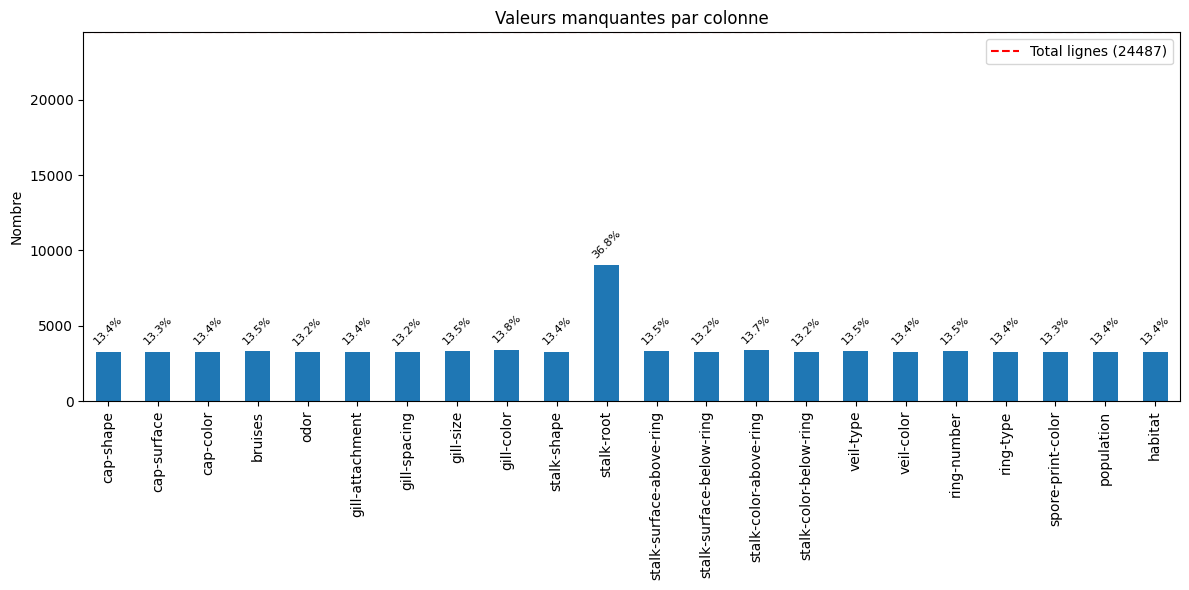

In [4]:
missing_count = df.isnull().sum()
missing_count = missing_count[missing_count > 0]
missing_pct = (missing_count / len(df)) * 100

fig, ax = plt.subplots(figsize=(12, 6))
missing_count.plot(kind='bar', ax=ax)
plt.title('Valeurs manquantes par colonne')
plt.ylabel('Nombre')
plt.ylim(0, len(df))
plt.axhline(y=len(df), color='red', linestyle='--', label=f'Total lignes ({len(df)})')

for i, (count, pct) in enumerate(zip(missing_count, missing_pct)):
    ax.text(i, count + len(df)*0.02, f'{pct:.1f}%', ha='center', rotation=45, fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()


 #### 2.4 Analyse des colonnes les plus deterministes (Cramer's V)

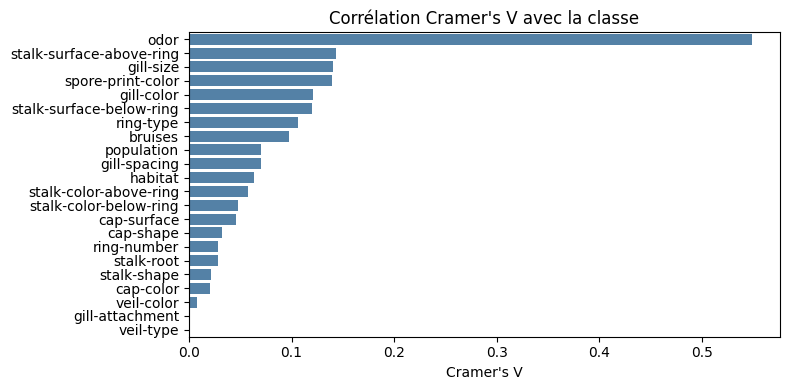

Top features : odor


In [5]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    if table.shape[0] == 1 or table.shape[1] == 1:
        return 0
    chi2 = chi2_contingency(table, correction=False)[0]
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

target = 'class'
features = df.drop(columns=[target]).columns

cramers = {col: cramers_v(df[col], df[target]) for col in features}
cramers = dict(sorted(cramers.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8, 4))
sns.barplot(x=list(cramers.values()), y=list(cramers.keys()), color="steelblue")
plt.title("Corrélation Cramer's V avec la classe")
plt.xlabel("Cramer's V")
plt.tight_layout()
plt.show()

top_feature = list(cramers.keys())[0]
print(f"Top features : {top_feature}")


  ### 3️⃣ Nettoyage des données

#### 3.1 Gérer les valeurs manquantes

In [6]:
# Supprimer la colonne la plus corrélée
# df = df.drop(columns=[top_feature])
# print(f"Colonne supprimée : {top_feature}")

# Remplacement des valeurs manquantes
df = df.fillna("Unknown")

# Suppression des colonnes avec trop de "Unknown" (>30%)
cols_to_drop = [col for col in df.columns if (df[col] == "Unknown").mean() > 0.3]
print("Colonnes supprimées :", cols_to_drop)
df = df.drop(columns=cols_to_drop)

# Suppression des lignes avec trop de "Unknown" (>20%)
rows_to_drop = [id for id in df.index if (df.loc[id] == "Unknown").mean() > 0.3]
print(f"Lignes supprimées : {len(rows_to_drop)}")
df = df.drop(index=rows_to_drop)

# Afficher le nombre de "Unknown" restants
unknown_count = (df == "Unknown").sum()
print(unknown_count[unknown_count > 0])


Colonnes supprimées : ['stalk-root']
Lignes supprimées : 413
cap-shape                   3154
cap-surface                 3111
cap-color                   3128
bruises                     3145
odor                        3102
gill-attachment             3151
gill-spacing                3067
gill-size                   3168
gill-color                  3218
stalk-shape                 3139
stalk-surface-above-ring    3169
stalk-surface-below-ring    3106
stalk-color-above-ring      3204
stalk-color-below-ring      3078
veil-type                   3157
veil-color                  3161
ring-number                 3146
ring-type                   3117
spore-print-color           3130
population                  3144
habitat                     3127
dtype: int64


  ### 4️⃣ Séparation features / target et train / test

In [7]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Shape avant encodage: ")
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Shape avant encodage: 
Train shape: (19259, 21)
Test shape : (4815, 21)


  ### 5️⃣ Modèle Random Forest

 #### 5.1 Définir le pipeline Random Forest sans optimisation (baseline)

In [8]:
rf_baseline_pipeline = Pipeline([
    ('encoder', OneHotEncoder(
        sparse_output=False,
        handle_unknown='ignore'
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])


#### 5.2 Entrainement et evaluation du Random Forest sans optimisation

In [9]:
# Entraînement
rf_baseline_pipeline.fit(X_train, y_train)

# Prédictions
y_train_pred_base = rf_baseline_pipeline.predict(X_train)
y_test_pred_base = rf_baseline_pipeline.predict(X_test)

# Scores
acc_train_base = accuracy_score(y_train, y_train_pred_base)
acc_test_base = accuracy_score(y_test, y_test_pred_base)

print("RANDOM FOREST BASELINE")
print(f"Accuracy Train : {acc_train_base:.4f}")
print(f"Accuracy Test  : {acc_test_base:.4f}")
print(classification_report(y_test, y_test_pred_base, target_names=['edible', 'poisonous']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_base))

RANDOM FOREST BASELINE
Accuracy Train : 0.7577
Accuracy Test  : 0.7375
              precision    recall  f1-score   support

      edible       0.78      0.72      0.75      2660
   poisonous       0.69      0.75      0.72      2155

    accuracy                           0.74      4815
   macro avg       0.74      0.74      0.74      4815
weighted avg       0.74      0.74      0.74      4815

Confusion Matrix:
 [[1926  734]
 [ 530 1625]]


 #### 5.3 Définir la pipeline Random Forest avec Optimisation GridSearchCV

In [10]:
rf_pipeline = Pipeline([
    ('encoder', OneHotEncoder(
        sparse_output=False,
        handle_unknown='ignore'
    )),
    ('classifier', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

#### 5.4 GridSearch

In [11]:
rf_param_grid = {
    'classifier__n_estimators': [200, 300, 500],
    'classifier__max_depth': [10, 15, 25],
    'classifier__min_samples_split': [5, 10, 15],
    'classifier__min_samples_leaf': [2, 4, 8]
}

# Créer un scorer personnalisé pour la classe "poisonous" (p)
recall_poisonous = make_scorer(recall_score, pos_label='p')

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring=recall_poisonous,  # ← Optimise le recall de "poisonous"
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres RF :", grid_search.best_params_)
print(f"Meilleure accuracy CV RF : {grid_search.best_score_:.4f}")

# Garder le meilleur pipeline
best_rf_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres RF : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 500}
Meilleure accuracy CV RF : 0.7771


#### 5.5 Analyse des résultats du gridsearch

ANALYSE DU GRIDSEARCH (optimisé sur Recall Poisonous)

Meilleure combinaison trouvée :
   CV Recall (Poisonous) : 0.7771

   Parametres :
   max_depth            : 10
   min_samples_leaf     : 8
   min_samples_split    : 5
   n_estimators         : 500

Top 3 des meilleures combinaisons :
 mean_test_score  param_classifier__n_estimators  param_classifier__max_depth
        0.777057                             500                           10
        0.777057                             500                           10
        0.777057                             500                           10


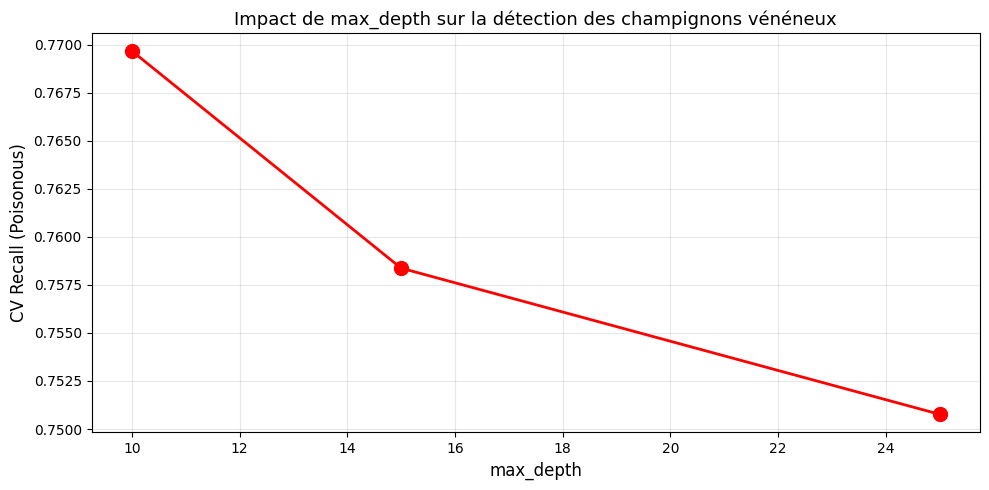


CONCLUSION :
   Le modele optimise la detection des champignons venéneux
   Recall Poisonous = 77.71%
   77.7% des champignons venéneux sont correctement detectes


In [12]:
import pandas as pd

# Récupérer tous les résultats du GridSearch
results_df = pd.DataFrame(grid_search.cv_results_)

print("ANALYSE DU GRIDSEARCH (optimisé sur Recall Poisonous)")

# 1. Meilleurs paramètres et score
print(f"\nMeilleure combinaison trouvée :")
print(f"   CV Recall (Poisonous) : {grid_search.best_score_:.4f}")
print(f"\n   Parametres :")
for param, value in grid_search.best_params_.items():
    param_name = param.replace('classifier__', '')
    print(f"   {param_name:20} : {value}")

# 2. Top 3 des meilleures combinaisons
print(f"\nTop 3 des meilleures combinaisons :")
top_3 = results_df.nsmallest(3, 'rank_test_score')[
    ['mean_test_score', 'param_classifier__n_estimators', 
     'param_classifier__max_depth']
]
print(top_3.to_string(index=False))

# 3. Graphique : Impact de max_depth
plt.figure(figsize=(10, 5))
depth_scores = results_df.groupby('param_classifier__max_depth')['mean_test_score'].mean().sort_index()
plt.plot(depth_scores.index, depth_scores.values, marker='o', linewidth=2, markersize=10, color='red')
plt.xlabel('max_depth', fontsize=12)
plt.ylabel('CV Recall (Poisonous)', fontsize=12)
plt.title('Impact de max_depth sur la détection des champignons vénéneux', fontsize=13)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Conclusion
print(f"\nCONCLUSION :")
print(f"   Le modele optimise la detection des champignons venéneux")
print(f"   Recall Poisonous = {grid_search.best_score_:.2%}")
print(f"   {grid_search.best_score_*100:.1f}% des champignons venéneux sont correctement detectes")

 #### 5.6 Évaluation du Random Forest avec GridSearch

In [13]:
results = {}

print("RANDOM FOREST RESULTS\n")

y_pred_train_gs = grid_search.best_estimator_.predict(X_train)
y_pred_test_gs = grid_search.best_estimator_.predict(X_test)

acc_train_gs = accuracy_score(y_train, y_pred_train_gs)
acc_test_gs = accuracy_score(y_test, y_pred_test_gs)

# Calculer recall et f1 pour le Random Forest
recall_gs = recall_score(y_test, y_pred_test_gs, pos_label='p')
f1_gs = f1_score(y_test, y_pred_test_gs, pos_label='p')

report_gs = classification_report(y_test, y_pred_test_gs, output_dict=True)
results['Random Forest'] = {
    'accuracy_train': acc_train_gs,
    'accuracy_test': acc_test_gs,
    'recall_poisonous': recall_gs, # On ajoute le recall ici pour la comparaison des modèles
    'f1_poisonous': f1_gs, 
    'f1_mean': (report_gs['e']['f1-score'] + report_gs['p']['f1-score']) / 2
}

print(f"\nAccuracy Train : {acc_train_gs:.4f}")
print(f"Accuracy Test  : {acc_test_gs:.4f}")
print(classification_report(y_test, y_pred_test_gs, target_names=['edible', 'poisonous']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_gs))


RANDOM FOREST RESULTS


Accuracy Train : 0.7844
Accuracy Test  : 0.7404
              precision    recall  f1-score   support

      edible       0.80      0.71      0.75      2660
   poisonous       0.68      0.78      0.73      2155

    accuracy                           0.74      4815
   macro avg       0.74      0.74      0.74      4815
weighted avg       0.75      0.74      0.74      4815

Confusion Matrix:
 [[1885  775]
 [ 475 1680]]


#### 5.7 Comparaison model baseline vs model avec GridSearch

In [14]:
from sklearn.metrics import recall_score, f1_score

# Calcul des métriques supplémentaires
recall_base = recall_score(y_test, y_test_pred_base, pos_label='p')
recall_gs = recall_score(y_test, y_pred_test_gs, pos_label='p')

f1_base = f1_score(y_test, y_test_pred_base, pos_label='p')
f1_gs = f1_score(y_test, y_pred_test_gs, pos_label='p')

# Affichage comparatif
print("COMPARAISON RANDOM FOREST : BASELINE vs OPTIMISÉ")

comparison_df = pd.DataFrame({
    'Métrique': ['Accuracy', 'Recall (Poisonous)', 'F1-Score (Poisonous)'],
    'Baseline': [acc_test_base, recall_base, f1_base],
    'Optimisé': [acc_test_gs, recall_gs, f1_gs],
    'Gain (%)': [
        (acc_test_gs - acc_test_base) * 100,
        (recall_gs - recall_base) * 100,
        (f1_gs - f1_base) * 100
    ]
})

print(comparison_df.to_string(index=False))

COMPARAISON RANDOM FOREST : BASELINE vs OPTIMISÉ
            Métrique  Baseline  Optimisé  Gain (%)
            Accuracy  0.737487  0.740395  0.290758
  Recall (Poisonous)  0.754060  0.779582  2.552204
F1-Score (Poisonous)  0.719982  0.728850  0.886805


  ### 6️⃣ Autres modèles 

 #### 6.1 Encoder les données explicitement

In [15]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

print("Shape Train encodé :", X_train_encoded.shape)
print("Shape Test encodé  :", X_test_encoded.shape)


Shape Train encodé : (19259, 133)
Shape Test encodé  : (4815, 133)


 #### 6.2 Définir les autres modèles

In [16]:
other_models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, 
        max_depth=10, 
        min_samples_split=5, 
        class_weight='balanced'
    ),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', 
        random_state=42
    )
}


 #### 6.3 Entraînement et évaluation des autres modèles

In [17]:
from sklearn.metrics import recall_score, f1_score

print("="*70)
print("AUTRES MODÈLES (encoding explicite)")
print("="*70)

for name, model in other_models.items():
    print(f"\n--- {name} ---")
    
    # Entraînement sur données encodées
    model.fit(X_train_encoded, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train_encoded)
    y_pred_test = model.predict(X_test_encoded)
    
    # Accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    # Recall et F1-score pour poisonous
    recall_test = recall_score(y_test, y_pred_test, pos_label='p')
    f1_test = f1_score(y_test, y_pred_test, pos_label='p')
    
    # Rapport
    report = classification_report(y_test, y_pred_test, output_dict=True)
    results[name] = {
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'recall_poisonous': recall_test,
        'f1_poisonous': f1_test,
        'f1_mean': (report['e']['f1-score'] + report['p']['f1-score']) / 2
    }
    
    print(f"Accuracy Train         : {acc_train:.4f}")
    print(f"Accuracy Test          : {acc_test:.4f}")
    print(f"Recall (Poisonous)     : {recall_test:.4f}")
    print(f"F1-Score (Poisonous)   : {f1_test:.4f}")
    print("\n" + classification_report(y_test, y_pred_test, target_names=['edible', 'poisonous']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

AUTRES MODÈLES (encoding explicite)

--- Decision Tree ---
Accuracy Train         : 0.7873
Accuracy Test          : 0.7057
Recall (Poisonous)     : 0.7002
F1-Score (Poisonous)   : 0.6805

              precision    recall  f1-score   support

      edible       0.75      0.71      0.73      2660
   poisonous       0.66      0.70      0.68      2155

    accuracy                           0.71      4815
   macro avg       0.70      0.71      0.70      4815
weighted avg       0.71      0.71      0.71      4815

Confusion Matrix:
 [[1889  771]
 [ 646 1509]]

--- AdaBoost ---
Accuracy Train         : 0.7532
Accuracy Test          : 0.7398
Recall (Poisonous)     : 0.6937
F1-Score (Poisonous)   : 0.7047

              precision    recall  f1-score   support

      edible       0.76      0.78      0.77      2660
   poisonous       0.72      0.69      0.70      2155

    accuracy                           0.74      4815
   macro avg       0.74      0.74      0.74      4815
weighted avg       0

  #### 6.4 Comparaison de tous les modèles

COMPARAISON DE TOUS LES MODÈLES
                     accuracy_test  recall_poisonous  f1_poisonous
Random Forest               0.7404            0.7796        0.7289
SVM                         0.7367            0.7619        0.7214
Logistic Regression         0.7358            0.7601        0.7203
Gradient Boosting           0.7454            0.7044        0.7123
Decision Tree               0.7057            0.7002        0.6805
AdaBoost                    0.7398            0.6937        0.7047


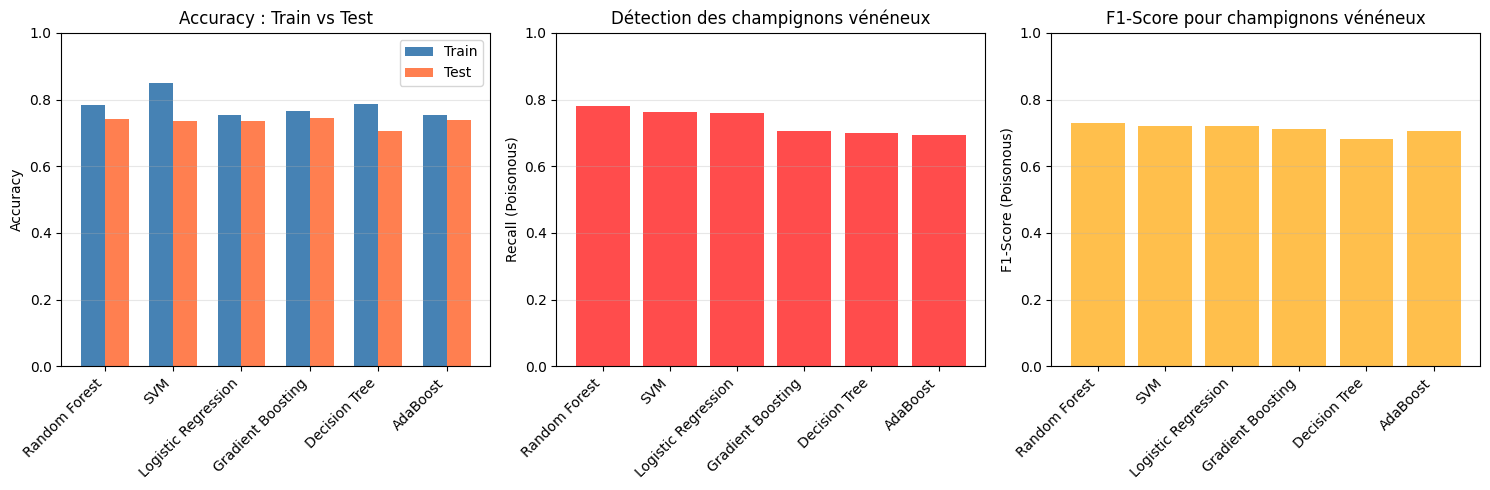

MEILLEURS MODÈLES PAR MÉTRIQUE
Meilleur Accuracy         : Gradient Boosting (0.7454)
Meilleur Recall (sécurité): Random Forest (0.7796)
Meilleur F1-Score         : Random Forest (0.7289)


In [18]:
print("COMPARAISON DE TOUS LES MODÈLES")

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('recall_poisonous', ascending=False)
# tableau comparatif de tous les modèles
cols_to_show = ['accuracy_test', 'recall_poisonous', 'f1_poisonous']
print(results_df[cols_to_show].round(4).to_string())

# Graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graphique 1 : Accuracy
x = np.arange(len(results_df))
width = 0.35
axes[0].bar(x - width/2, results_df['accuracy_train'], width, label='Train', color='steelblue')
axes[0].bar(x + width/2, results_df['accuracy_test'], width, label='Test', color='coral')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy : Train vs Test')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Graphique 2 : Recall Poisonous
x = np.arange(len(results_df)) 
axes[1].bar(x, results_df['recall_poisonous'], color='red', alpha=0.7)
axes[1].set_ylabel('Recall (Poisonous)')
axes[1].set_title('Détection des champignons vénéneux')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# Graphique 3 : F1-Score Poisonous
axes[2].bar(x, results_df['f1_poisonous'], color='orange', alpha=0.7)
axes[2].set_ylabel('F1-Score (Poisonous)')
axes[2].set_title('F1-Score pour champignons vénéneux')
axes[2].set_xticks(x)
axes[2].set_xticklabels(results_df.index, rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Meilleur modèle selon différentes métriques
print("MEILLEURS MODÈLES PAR MÉTRIQUE")
print(f"Meilleur Accuracy         : {results_df['accuracy_test'].idxmax()} ({results_df['accuracy_test'].max():.4f})")
print(f"Meilleur Recall (sécurité): {results_df['recall_poisonous'].idxmax()} ({results_df['recall_poisonous'].max():.4f})")
print(f"Meilleur F1-Score         : {results_df['f1_poisonous'].idxmax()} ({results_df['f1_poisonous'].max():.4f})")

  ### 8️⃣ Sauvegarde du modèle Random Forest

In [19]:
model_file_name = "../models/mushroom_machine_learning.pkl"
joblib.dump(best_rf_pipeline, model_file_name)
print(f"Modele sauvegardé : {model_file_name}")
print(f"Accuracy Test : {acc_test_gs:.4f}")

Modele sauvegardé : ../models/mushroom_machine_learning.pkl
Accuracy Test : 0.7404


### 9️⃣ Évaluation sur données d'évaluation externes

#### 9.1 Chargement des données d'évaluation

In [20]:
# Charger le dataset d'évaluation
df_eval = pd.read_csv("../dataset/mushroom_eval.csv", sep=';')
print(f"Données d'évaluation chargées : {df_eval.shape}")
df_eval.describe()

Données d'évaluation chargées : (1499, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,1499,1310,1286,1310,1327,1284,1304,1324,1309,1304,...,1317,1288,1296,1305,1285,1304,1268,1275,1277,1293
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,829,452,445,291,751,400,1028,921,797,204,...,618,490,502,1305,880,909,444,295,469,371


#### 9.2 Preprocessing sur données d'évaluation finale

In [21]:
# Appliquer le même nettoyage 
df_eval = df_eval.fillna("Unknown")

print(f"\n cols avant suppression : {cols_to_drop}")

# Supprimer les mêmes colonnes que sur le train
if cols_to_drop:
    df_eval = df_eval.drop(columns=[col for col in cols_to_drop if col in df_eval.columns])

# Séparer features et target
X_eval = df_eval.drop(columns=['class'])
y_eval = df_eval['class']

print(f"X_eval shape : {X_eval.shape}")
print(f"y_eval shape : {y_eval.shape}")


 cols avant suppression : ['stalk-root']
X_eval shape : (1499, 21)
y_eval shape : (1499,)


#### 9.3 Prédictions sur le dataset d'évaluation

In [22]:
y_eval_pred = best_rf_pipeline.predict(X_eval)

# Calcul des métriques
eval_acc = accuracy_score(y_eval, y_eval_pred)
eval_recall = recall_score(y_eval, y_eval_pred, pos_label='p')

print(f"RÉSULTATS SUR LE DATASET D'ÉVALUATION")
print(f"\nEval Accuracy          : {eval_acc:.4f} ({eval_acc*100:.2f}%)")
print(f"Eval Recall (Poisonous): {eval_recall:.4f} ({eval_recall*100:.2f}%)")

RÉSULTATS SUR LE DATASET D'ÉVALUATION

Eval Accuracy          : 0.7505 (75.05%)
Eval Recall (Poisonous): 0.7940 (79.40%)


#### 9.4 Matrice de confusion et rapport de classification

              precision    recall  f1-score   support

      edible       0.81      0.72      0.76       829
   poisonous       0.69      0.79      0.74       670

    accuracy                           0.75      1499
   macro avg       0.75      0.75      0.75      1499
weighted avg       0.76      0.75      0.75      1499



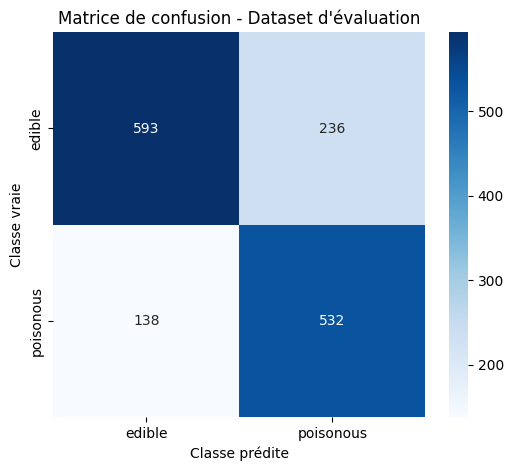

In [23]:
# Rapport de classification
print(classification_report(y_eval, y_eval_pred, target_names=['edible', 'poisonous']))

# Matrice de confusion
cm_eval = confusion_matrix(y_eval, y_eval_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['edible', 'poisonous'], 
            yticklabels=['edible', 'poisonous'])
plt.xlabel('Classe prédite')
plt.ylabel('Classe vraie')
plt.title('Matrice de confusion - Dataset d\'évaluation')
plt.show()

#### 9.5 Comparaison des performances entre test et évaluation avec des données externes

COMPARAISON DES PERFORMANCES (Test vs Eval)

Test  :  4815 données | Accuracy : 0.7404 | Recall (P) : 0.7796 | Faux Positifs : 475
Eval  :  1499 données | Accuracy : 0.7505 | Recall (P) : 0.7940 | Faux Positifs : 138

Écart Test-Eval (Accuracy) : 1.01%
Écart Test-Eval (Recall)   : 1.44%


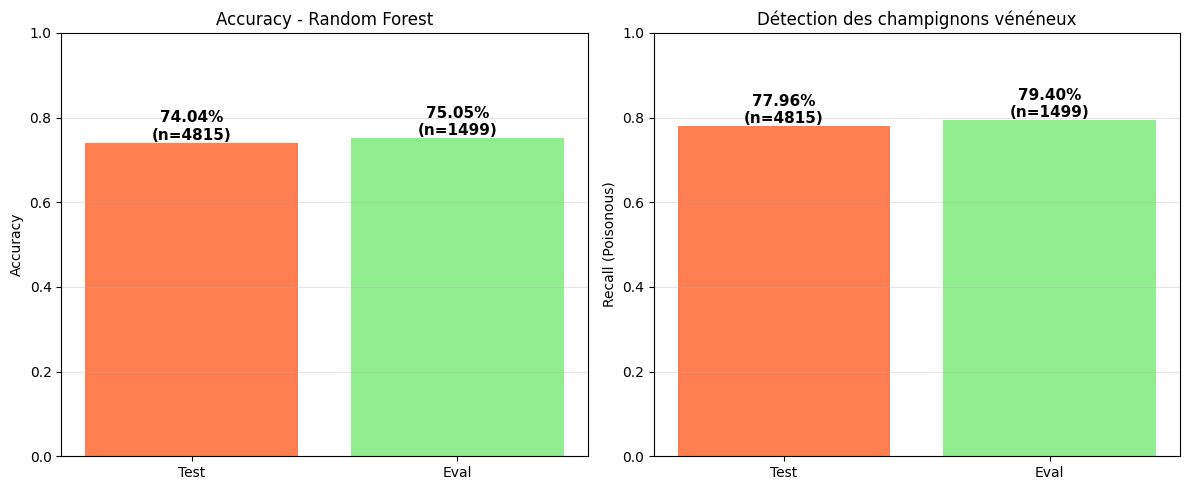

Excellente généralisation (écart < 2%)


In [24]:
from sklearn.metrics import confusion_matrix

# Calculer les faux positifs (prédit edible mais vraiment poisonous)
cm_test = confusion_matrix(y_test, y_pred_test_gs, labels=['e', 'p'])
fp_test = cm_test[1, 0]  # Ligne poisonous, colonne edible

cm_eval = confusion_matrix(y_eval, y_eval_pred, labels=['e', 'p'])
fp_eval = cm_eval[1, 0]

print(f"COMPARAISON DES PERFORMANCES (Test vs Eval)")
print(f"\nTest  : {len(X_test):5} données | Accuracy : {acc_test_gs:.4f} | Recall (P) : {recall_gs:.4f} | Faux Positifs : {fp_test}")
print(f"Eval  : {len(X_eval):5} données | Accuracy : {eval_acc:.4f} | Recall (P) : {eval_recall:.4f} | Faux Positifs : {fp_eval}")
print(f"\nÉcart Test-Eval (Accuracy) : {abs(acc_test_gs - eval_acc)*100:.2f}%")
print(f"Écart Test-Eval (Recall)   : {abs(recall_gs - eval_recall)*100:.2f}%")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

datasets = ['Test', 'Eval']
accuracies = [acc_test_gs, eval_acc]
recalls = [recall_gs, eval_recall]
sizes = [len(X_test), len(X_eval)]

# Graphique 1 : Accuracy
bars1 = axes[0].bar(datasets, accuracies, color=['coral', 'lightgreen'])
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy - Random Forest')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', alpha=0.3)

for bar, acc, size in zip(bars1, accuracies, sizes):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                 f'{acc:.2%}\n(n={size})',
                 ha='center', va='bottom', fontsize=11, weight='bold')

# Graphique 2 : Recall Poisonous
bars2 = axes[1].bar(datasets, recalls, color=['coral', 'lightgreen'])
axes[1].set_ylabel('Recall (Poisonous)')
axes[1].set_title('Détection des champignons vénéneux')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', alpha=0.3)

for bar, recall, size in zip(bars2, recalls, sizes):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                 f'{recall:.2%}\n(n={size})',
                 ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

# Conclusion
diff_test_eval = abs(acc_test_gs - eval_acc) * 100

if diff_test_eval < 2:
    print("Excellente généralisation (écart < 2%)")
elif diff_test_eval < 5:
    print("Bonne généralisation (écart < 5%)")
else:
    print(f"Attention : écart significatif de {diff_test_eval:.2f}%")